Got code working for one 3D image. next steps:
- get code working for all images in the post directory (for loop on the images in the directory)
- get results for pre vs post
- check if need other metrics besides jaccard and dice
- train medsam, also use test, val split
- use Brain MRI Dataset of Multiple Sclerosis with Consensus Manual Lesion Segmentation and Patient Meta Information data

# 0. Import and install packages, define functions

In [ ]:
from google.colab import drive
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np
from torchmetrics.classification import Dice, JaccardIndex
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F


drive.mount('/content/drive')

In [ ]:
POST_DIR = '/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/post_train/'
MASK_DIR = '/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/tumor_mask_train/'
PRE_DIR = '/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/pre_train/'
img_name = os.listdir(POST_DIR)[1].split("_", maxsplit = 3)
slice_ind = 80

In [ ]:
!pip install torchmetrics

In [2]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git
# takes 24 seconds

  Preparing metadata (setup.py) ... done


In [3]:
# # download model and data
# !wget -O img_demo.png https://pngraw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
# !wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

In [6]:
# %cd '/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/tumor_mask_train'
# # %cd MASK_DIR
# %ls -U | head -4

In [7]:
# %cd '/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/post_train'
# # %cd POST_DIR
# %ls -U | head -4

In [ ]:
# visualize_masks(nii_img)
# plt.imshow(nii_data[:,:,80])
# plt.show()

## Self-defined functions

In [8]:
def convert_to_binary(arr):
    return np.where(arr > 0, 1, 0)

In [9]:
def visualize_masks(nii_img):
    nii_aff  = nii_img.affine
    nii_hdr  = nii_img.header

    # print(nii_aff ,'\n',nii_hdr)
    # print(nii_data.shape)
    nii_data = nii_img.get_fdata()
    number_of_slices = nii_data.shape[1]
    number_of_frames = nii_data.shape[2]
    number_of_frames = 1

    # Define the number of columns for subplot
    num_columns = 5

    if(len(nii_data.shape)==3):
        start_slice = 80
        end_slice = 100
        num_slices = end_slice - start_slice + 1
        num_rows = num_slices // num_columns + 1

        fig, ax = plt.subplots(num_rows, num_columns, figsize=(10,10))

        for i in range(start_slice, end_slice+1):
            row = (i-start_slice) // num_columns
            col = (i-start_slice) % num_columns
            ax[row, col].imshow(nii_data[:,:,i])
            ax[row, col].axis('off')

        # Remove empty subplots
        for j in range(i-start_slice+1, num_rows*num_columns):
            fig.delaxes(ax.flatten()[j])

        plt.show()

In [11]:
def box_coordinates_from_mask(mask, margin = 5):
    nonzero_indices = np.transpose(np.nonzero(mask))

    min_y = np.min(nonzero_indices[:, 0])
    max_y = np.max(nonzero_indices[:, 0])
    min_x = np.min(nonzero_indices[:, 1])
    max_x = np.max(nonzero_indices[:, 1])

    margin = 5

    x0 = min_x - margin
    y0 = min_y - margin
    x1 = max_x + margin
    y1 = max_y + margin

    # print(f"Row and column for non-zero elements with greatest x range: [{min_x}, {max_x}]")
    # print(f"Row and column for non-zero elements with greatest y range: [{min_y}, {max_y}]")
    return x0, y0, x1, y1

## MedSAM functions

In [12]:
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    # print("x_0, y_0", x0, y0)
    # print("w, h", w, h)
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


# 1. Load model and images

In [23]:
nii_img  = nib.load(POST_DIR + f"{img_name[0]}_{img_name[1]}_t1ce.nii.gz" ) # Nifti1Image
nii_mask  = nib.load(MASK_DIR + f"{img_name[0]}_{img_name[1]}_seg.nii.gz") # Nifti1Image
np_img = nii_img.get_fdata() # np array
np_mask = convert_to_binary(nii_mask.get_fdata())

In [14]:
#%% load model and image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

In [15]:
# img_np = io.imread('/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/pre_train/img_demo.png')

# 2. Model inference

In [26]:
dice_results = []
jaccard_results = []
slice_indexes = []
for slice_ind in range(nii_mask.shape[-1]):
    #% image preprocessing part 1
    img_np = np_img[:,:,slice_ind]
    mask_np = np_mask[:,:,slice_ind]
    if np.sum(mask_np) < 10:
        continue
    slice_indexes.append(slice_ind)
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    H, W, _ = img_3c.shape

    #%% image preprocessing part 2
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

    # box_np = np.array([[95,255, 190, 350]])
    x0, y0, x1, y1 = box_coordinates_from_mask(mask_np)
    box_np = np.array([[x0,y0, x1, y1]])
    # transfer box_np t0 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

    #% model inference
    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

    #% metric calculation
    dice = Dice(average='micro')
    jaccard = JaccardIndex(task="multiclass", num_classes=2)
    target = torch.IntTensor(convert_to_binary(img_np))
    preds = torch.IntTensor(medsam_seg)
    # print(target.shape)
    # print(preds.shape)
    dice_results.append(dice(preds, target))
    jaccard_results.append(jaccard(preds, target))

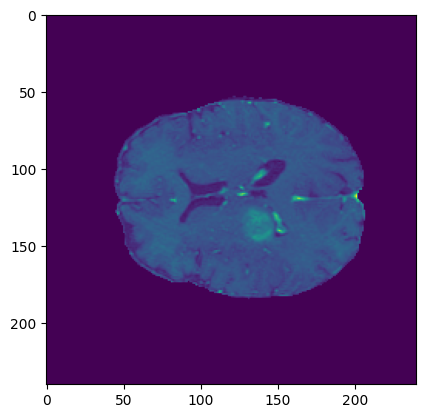

In [17]:
# visualize input
plt.imshow(img_np)

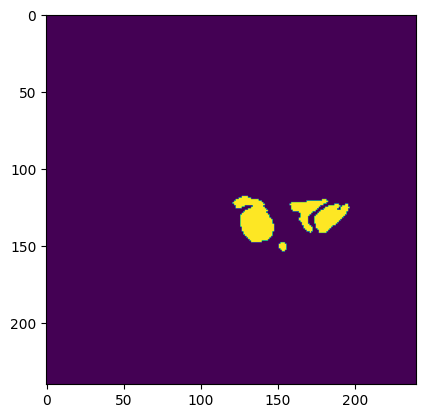

In [18]:
plt.imshow(mask_np)

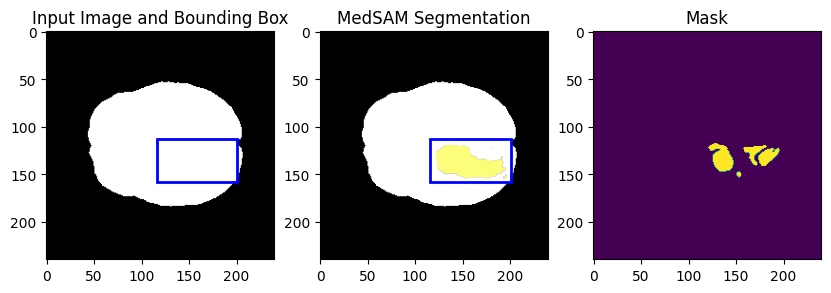

In [19]:
#%% visualize results
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")

ax[2].imshow(mask_np)
ax[2].set_title("Mask")
plt.show()

In [20]:
dice = Dice(average='micro')
jaccard = JaccardIndex(task="multiclass", num_classes=2)
target = torch.IntTensor(convert_to_binary(img_np))
preds = torch.IntTensor(medsam_seg)
# print(target.shape)
# print(preds.shape)
dice(preds, target)
jaccard(preds, target)

tensor(0.4100)